<a name="top"></a><img src="./source/SpinalHDL.png" alt="SpinalHDL based on Scala" style="width:320px;" />

  Before running Spinal HDL code, be sure to load Spinal HDL Libraries  
**Note** : This may be a little slow when the first time load, please wait a moment to download Lib from remote.)

In [ ]:
val path = System.getProperty("user.dir") + "/source/load-spinal.sc"
interp.load.module(ammonite.ops.Path(java.nio.file.FileSystems.getDefault().getPath(path)))

## Sequential Logic


There is 4 ways to instantiate a **register**: 

Syntax | Description
-|-
Reg(type : Data) |Register of the given type
RegInit(resetValue : Data)|Register loaded with the given resetValue when a reset occurs
RegNext(nextValue : Data) |Register that samples the given nextValue each cycle
RegNextWhen(nextValue : Data, cond : Bool)|Register that samples the given nextValue when a condition occurs

In [ ]:
class Top extends Component{ 
val cond = in Bool()
//UInt register of 4 bits
val reg1 = Reg(UInt(4 bit))

//Register that samples reg1 each cycle
val reg2 = RegNext(reg1 + 1)

//UInt register of 4 bits initialized with 0 when the reset occurs
val reg3 = RegInit(U"0000")
reg3 := reg2
when(reg2 === 5){
  reg3 := 0xF
}

//Register that samples reg3 when cond is True
val reg4 = RegNextWhen(reg3,cond)
}
showRtl(new Top)

The code above will infer the following logic:
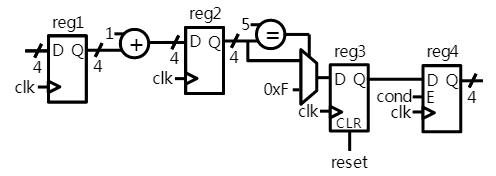
Also, RegNext is an abstraction which is built over the Reg syntax. The two following sequences of code are strictly equivalent:

In [ ]:
class Top extends Component{
  //Standard way
  val something = Bool()
  val value = Reg(Bool())
  value := something

  //Short way
  val something1 = Bool()
  val value1 = RegNext(something)
}
showRtl(new Top)

#### Reset Value
In addition to the RegInit(value : Data) syntax which directly creates the register with a reset value, you can also set the reset value by calling the init(value : Data) function on the register.

If you have a register containing a Bundle, you can use the init function on each element of the Bundle.

In [ ]:
case class ValidRGB() extends Bundle{
  val valid = Bool()
  val r,g,b = UInt(8 bits)
}

class Top extends Component{
  val reg = Reg(ValidRGB())
  reg.valid init(False)  //Only the valid of that register bundle will have an reset value.
}
showRtl(new Top)

#### Initialization value for simulation purposes
For registers that don’t need a reset value in RTL, but need an initialization value for simulation (to avoid x-propagation), you can ask for an random initialization value by calling the randBoot() function.

In [ ]:
class Top extends Component{
  val reg1 = Reg(UInt(4 bit)) randBoot()
}
showRtl(new Top)

##  [RAM/ROM](https://spinalhdl.github.io/SpinalDoc-RTD/SpinalHDL/Sequential%20logic/memory.html)
To create a memory in SpinalHDL, the Mem class should be used. It allows you to define a memory and add read and write ports to it.

In [ ]:
class Top extends Component{
 val io = new Bundle{
        val writeValid = in Bool()
        val writeAddress = in UInt(8 bits)
        val writeData = in Bits(32 bits)
        val readValid = in Bool()
        val readAddress = in UInt(8 bits)
        val readData = out Bits(32 bits)
    }
 val mem = Mem(Bits(32 bits),wordCount = 256)
 mem.write(
  enable  = io.writeValid,
  address = io.writeAddress,
  data    = io.writeData
 )

 io.readData := mem.readSync(
  enable  = io.readValid,
  address = io.readAddress
 )
 }
showRtl(new Top)

As for Read under write policy, to use this feature you need to enable the automatic memory blackboxing, because there is no universal VHDL/Verilog language template to infer mixed width ram.
#### Blackboxing policy
There are multiple policies that you can use to select which memory you want to blackbox and also what to do when the blackboxing is not feasible:

Kinds | Description
-|-
blackboxAll | Blackbox all memory.<br> Throw an error on unblackboxable memory  
blackboxAllWhatsYouCan | Blackbox all memory that is blackboxable
blackboxRequestedAndUninferable | Blackbox memory specified by the user and memory that is known to be uninferable (mixed width, …). <br>  Throw an error on unblackboxable memory  
blackboxOnlyIfRequested | Blackbox memory specified by the user <br>  Throw an error on unblackboxable memory

In [ ]:
SpinalConfig(targetDirectory="rtl/")
    .addStandardMemBlackboxing(blackboxAll)
    .generateVerilog(new Top)
scala.io.Source.fromFile("rtl/TopTopLevel.v").mkString

To explicitly set a memory to be blackboxed, you can use its `generateAsBlackBox` function.

In [ ]:
import spinal.lib.graphic._
class Top extends Component{
    val io = new Bundle{
        val writeValid = in Bool()
        val writeAddress = in UInt(8 bits)
        val writeData = in(Rgb(RgbConfig(8,8,8)))
        val readValid = in Bool()
        val readAddress = in UInt(8 bits)
        val readData = out(Rgb(RgbConfig(8,8,8)))
    }
    
 val mem = Mem(Rgb(RgbConfig(8,8,8)),1024)
    
 mem.generateAsBlackBox() // explicitly set a memory to be blackboxed
   
 mem.write(
  enable  = io.writeValid,
  address = io.writeAddress,
  data    = io.writeData
 )

 io.readData := mem.readSync(
  enable  = io.readValid,
  address = io.readAddress
 )
}
showRtl(new Top)    

As you can see, blackboxes have a technology parameter. To set it you can use the setTechnology function on the corresponding memory. There are currently 4 kinds of technogy possible:
- auto
- ramBlock
- distributedLut
- registerFile

```scala
class Top extends Component{
  ...
  val mem = Mem(Bits(32 bits),wordCount = 256)
  mem.setTechnology(tech=ramBlock)
  mem.generateAsBlackBox()
  ...
}
```